# Example 2 (FastBNB)

This notebook shows predictions for nueCCQE-like events at MiniBooNE using the "fastbnb" module -- installed separately from:

[github.com/mhostert/MiniBooNE-DarkNews](https://github.com/mhostert/MiniBooNE-DarkNews)

In this second MiniBooNE example, we explore some good fits to the MiniBooNE spectra. For more infor, see [this paper](https://arxiv.org/abs/2308.02543).

The idea is to choose some mediator and HNL masses that make sense and then minimize the MiniBooNE EnueCCQE chi2 by varying the upscattering couplings.

We do this for a TMM, vector, and scalar mediator models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
from scipy.optimize import minimize
import numpy as np
import pandas as pd

import DarkNews as dn
from DarkNews import const

import fastbnb as fb
from fastbnb import plot_tools as pt2
from fastbnb import decayer, analysis
try:
    from importlib.resources import files
except ImportError:
    from importlib_resources import files

### Some useful functions to generate and interpret our MiniBooNE simulation

In [8]:
common_kwargs = {'loglevel': 'ERROR', 'HNLtype': 'dirac', 'neval': 1e4, 'include_nelastic': True, 'noHC': False, 'noHF': False, 'nu_flavors': ['nu_mu']}

def get_event_rate(kwargs, common_kwargs=common_kwargs, include_dirt=True):
    df_det = dn.GenLauncher(experiment="miniboone_fhc", **common_kwargs, **kwargs).run()
    
    if include_dirt:
        df_dirt = dn.GenLauncher(experiment="miniboone_fhc_dirt", **common_kwargs, **kwargs).run()
        df_nu = pd.concat([df_det, df_dirt])
    else:
        df_nu = df_det

    if 'm5' in kwargs.keys():
        decay_l = df_det.attrs['N5_ctau0']
    else:
        decay_l = df_det.attrs['N4_ctau0']

    df_nu_reco = analysis.reco_nueCCQElike_Enu(decayer.decay_selection(df_nu, decay_l, "miniboone", weights="w_event_rate"))

    return df_nu_reco

In [9]:
def get_pval(df_prob, ndof=8.7):
    bin_e = np.genfromtxt(
        files("fastbnb.include.MB_data_release.combined").joinpath("miniboone_binboundaries_nue_lowe.txt").open())
    NP_MC, _ = np.histogram(df_prob['reco_Enu']*1e3, weights=df_prob['reco_w'], bins=bin_e)
    bw = bin_e[1:]-bin_e[:-1]
    # plt.step((bin_e[1:]+bin_e[:-1])/2,NP_MC/bw, where ='mid')
    chi2= fb.fit_functions.chi2_MiniBooNE_2020(NP_MC, NP_MC.sum())
    return scipy.stats.chi2.sf(chi2, ndof)


def get_pval_nevents(df_prob, nevents, ndof=8.7):
    bin_e = np.genfromtxt(
        files("fastbnb.include.MB_data_release.combined").joinpath("miniboone_binboundaries_nue_lowe.txt").open())
    wreco = df_prob['reco_w']*nevents/df_prob['reco_w'].sum()
    NP_MC, _ = np.histogram(df_prob['reco_Enu']*1e3, weights=wreco, bins=bin_e)
    chi2= fb.fit_functions.chi2_MiniBooNE_2020(NP_MC, NP_MC.sum())
    return scipy.stats.chi2.sf(chi2, ndof)


def print_summary_of_event(df, col='reco_w', summary='Events'):
    coherent = (df['scattering_regime'] == 'coherent')
    pel = (df['scattering_regime'] == 'p-el')
    nel = (df['scattering_regime'] == 'n-el')
    print(f"{summary}: {df[col].sum():.2g} total ({df[col][coherent].sum():.2g} coh : {df[col][pel].sum():.2g} pel : {df[col][nel].sum():.2g} nel) -- pval = {get_pval(df)*100:.3f}%")


### Generating events

In [10]:
# TMM
delta_TMM = 0.3
# kwargs = {'mu_tr_mu4': 1.2e-6*2, 'm4': 0.470, 'decay_product': 'photon'} # 3+1
kwargs = {'mu_tr_mu5': 1.2e-6*2, 'mu_tr_45': 1e-6, 'm5': 0.470, 'm4': 0.470/(1+delta_TMM), 'decay_product': 'photon'} # 3+2
df_0 = get_event_rate(kwargs)

# Vectors
DELTA = 1
M5 = 0.2
M4 = M5 / (1 + DELTA)
kwargs = {'d_mu5': 0.0002, 'd_45': 1, 'dprotonV': 3.4e-4*const.eQED, 'deV': 3.4e-4*const.eQED, 'mzprime': 0.03, 'm4': M4, 'm5': M5}
df_1 = get_event_rate(kwargs)

eps = 2e-3
kwargs = {'d_mu5': 0.01, 'd_45': 1, 'dprotonV': eps*const.eQED, 'deV': eps*const.eQED, 'mzprime': 1.25, 'm4': M4, 'm5': M5}
# kwargs = {'UD4': 1/np.sqrt(2), 'UD5': 1/np.sqrt(2), 'Umu5': 1e-3, 'Umu4': 1e-3, 'gD': 2, 'epsilon': 0.75e-2, 'mzprime': 1.25, 'm4': M4, 'm5': M5} # 3 portal
df_2 = get_event_rate(kwargs)

# Scalars
theta_e = 2e-3
theta_numu = 3e-3
theta_nucleon = 3e-3
kwargs = {'mzprime': None, 'mhprime': 1.0, 'm4': M4, 'm5': M5, 's_mu5': theta_numu, 's_45': 1.0,  'deS': theta_e, 'dprotonS': theta_nucleon, 'dneutronS': theta_nucleon}
df_3 = get_event_rate(kwargs)

theta_e = 0.8e-3
theta_numu = 1e-3
theta_nucleon = 1.1e-4
kwargs = {'mzprime': None, 'mhprime': 0.03, 'm4': M4, 'm5': M5, 's_mu5': theta_numu, 's_45': 1.0,  'deS': theta_e, 'dprotonS': theta_nucleon, 'dneutronS': theta_nucleon}
df_4 = get_event_rate(kwargs)

In [11]:
print_summary_of_event(df_0)
print_summary_of_event(df_1)
print_summary_of_event(df_2)
print_summary_of_event(df_3)
print_summary_of_event(df_4)

Events: 5.4e+02 total (2.4e+02 coh : 3e+02 pel : 9.3e-09 nel) -- pval = 36.676%
Events: 4.5e+02 total (3.6e+02 coh : 92 pel : 0 nel) -- pval = 28.423%
Events: 9.3e+02 total (2.9e+02 coh : 6.4e+02 pel : 0 nel) -- pval = 43.986%
Events: 8.1e+02 total (2.7e+02 coh : 3.8e+02 pel : 1.5e+02 nel) -- pval = 22.266%
Events: 8.5e+02 total (7.5e+02 coh : 59 pel : 43 nel) -- pval = 59.249%


624.6404778396793
783.1227804217625
729.8398248521028
682.9289167570857
779.8597001359492


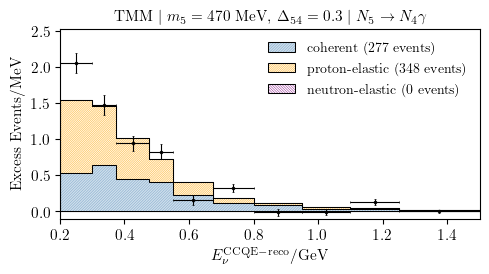

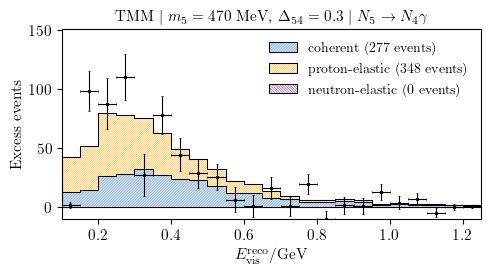

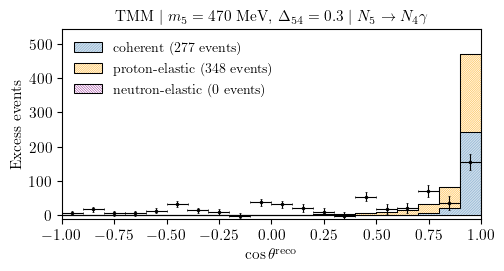

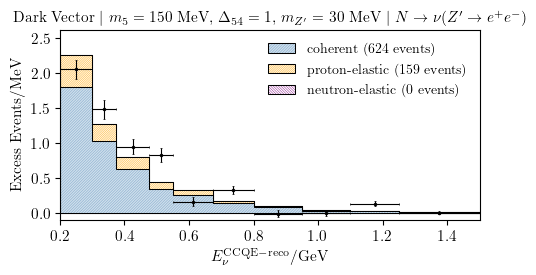

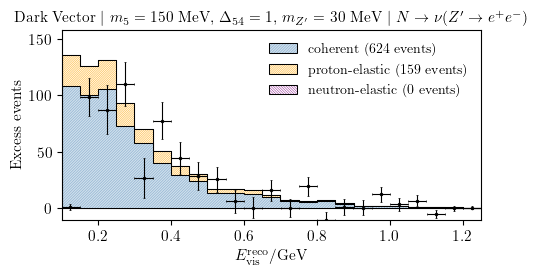

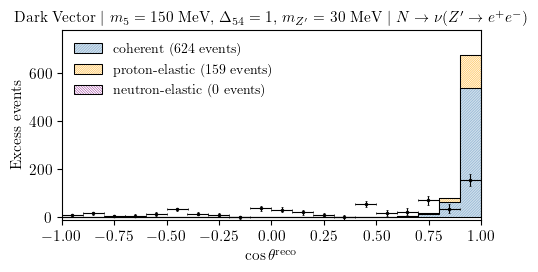

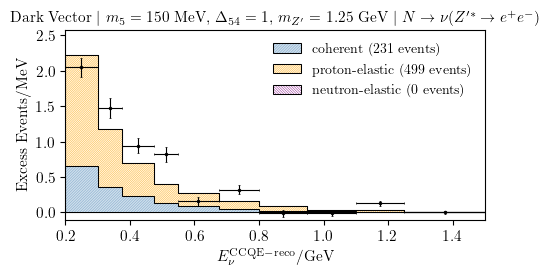

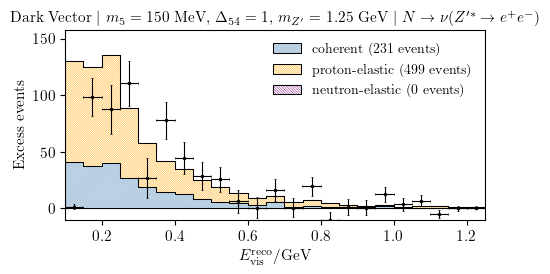

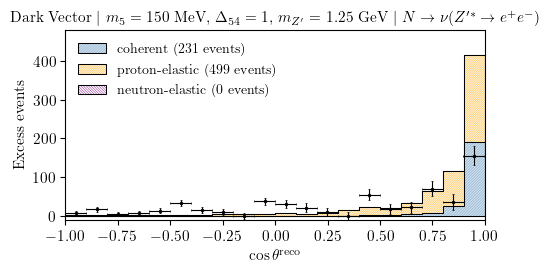

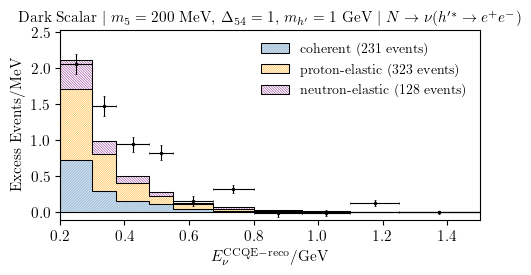

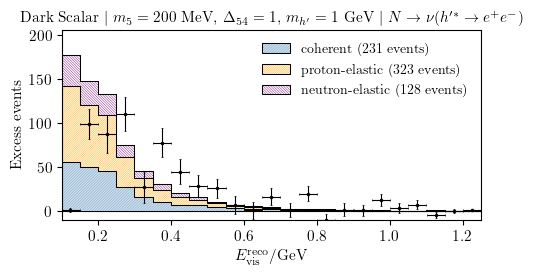

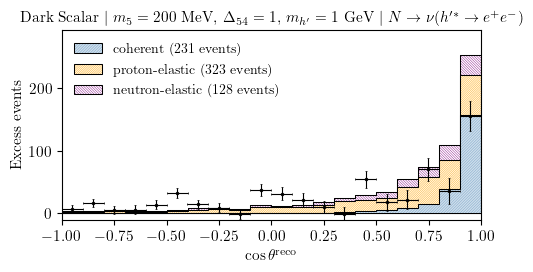

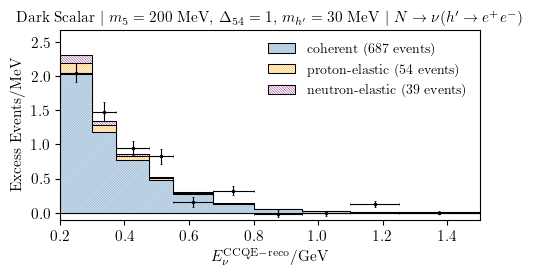

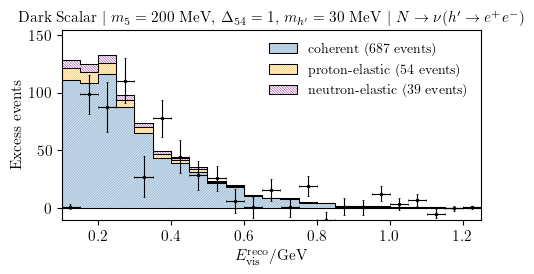

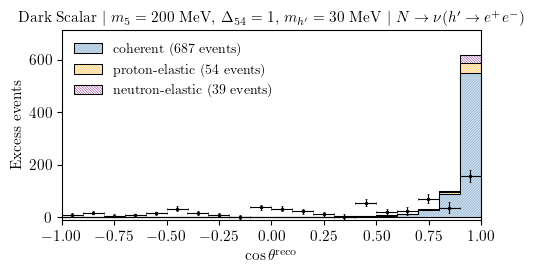

In [12]:
pt2.batch_plot_signalMB(df_0, Nevents=minimize(lambda x: 1/get_pval_nevents(df_0, x), x0=(500)).x[0], PATH='plots/', title=rf'TMM  $\vert$ $m_5 = 470$ MeV, $\Delta_{{54}} = {delta_TMM}$ $\vert$  $N_5 \to N_4 \gamma$', prefix='BP0_split', bkg_subtract=True)
pt2.batch_plot_signalMB(df_1, Nevents=minimize(lambda x: 1/get_pval_nevents(df_1, x), x0=(500)).x[0], PATH='plots/', title=r'Dark Vector $\vert$ $m_5 = 150$ MeV, $\Delta_{54} = 1$, $m_{Z^\prime} = 30$ MeV $\vert$ $N\to \nu (Z^\prime \to e^+e^-)$', prefix='BP1', bkg_subtract=True)
pt2.batch_plot_signalMB(df_2, Nevents=minimize(lambda x: 1/get_pval_nevents(df_2, x), x0=(500)).x[0], PATH='plots/', title=r'Dark Vector $\vert$ $m_5 = 150$ MeV, $\Delta_{54} = 1$, $m_{Z^\prime} = 1.25$ GeV  $\vert$ $N\to \nu (Z^{\prime *} \to e^+e^-)$', prefix='BP2', bkg_subtract=True)
pt2.batch_plot_signalMB(df_3, Nevents=minimize(lambda x: 1/get_pval_nevents(df_3, x), x0=(500)).x[0], PATH='plots/', title=r'Dark Scalar $\vert$ $m_5 = 200$ MeV, $\Delta_{54} = 1$, $m_{h^\prime} = 1$ GeV $\vert$ $N\to \nu (h^{\prime *} \to e^+e^-)$', prefix='BP3', bkg_subtract=True)
pt2.batch_plot_signalMB(df_4, Nevents=minimize(lambda x: 1/get_pval_nevents(df_4, x), x0=(500)).x[0], PATH='plots/', title=r'Dark Scalar $\vert$ $m_5 = 200$ MeV, $\Delta_{54} = 1$, $m_{h^\prime} = 30$ MeV $\vert$ $N\to \nu (h^\prime \to e^+e^-)$', prefix='BP4', bkg_subtract=True)